In [62]:
import pandas as pd
from collections import Counter
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import sys
import os
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage,leaves_list
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import hamming, squareform
from scipy.spatial.distance import pdist, jaccard

BLOOD_MICROBIOME_PATH = '/home/groups/dpwall/briannac/blood_microbiome/'
fig_dir=BLOOD_MICROBIOME_PATH + 'results/abundances/'

sys.path.append('/home/groups/dpwall/briannac/blood_microbiome/src')
bam_mappings_file = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'

bacteria_file = BLOOD_MICROBIOME_PATH + 'data/kraken_align/bacteria_filtered_species.df' 
virus_file = BLOOD_MICROBIOME_PATH + 'data/kraken_align/virus_filtered_species.df' 

# Filter

## Load / format data

In [53]:
bam_mappings = pd.read_csv(bam_mappings_file, sep='\t', index_col=1)
df_bacteria = pd.read_pickle(bacteria_file)
df_virus  = pd.read_pickle(virus_file)

In [54]:
df_virus.index = [i[2] for i in df_virus.index]
df_bacteria.index = [i[2] for i in df_bacteria.index]
df_virus = df_virus.transpose()
df_bacteria = df_bacteria.transpose()

# Microbe Abundance Plots
## Virus

In [55]:
virus_abundant = df_virus.columns[np.argsort(df_virus.sum())[::-1]]
virus_prevalent = []#df_virus.columns[np.argsort((df_virus>0).sum())[::-1]][:25]
select_viruses = list(set(virus_abundant).union(set(virus_prevalent)))
len(select_viruses)

51

In [56]:
# Hacky way to make cylical color palette.
a=np.concatenate([[tuple(i) for i in sns.color_palette("husl", 34)[n::5]] for n in range(5)])
a = [tuple(i) for i in a]
palette = ['#%02x%02x%02x' % (int(i[0]*255), int(i[1]*255), int(i[2]*255)) for i in a]
hierarchy.set_link_color_palette(palette)

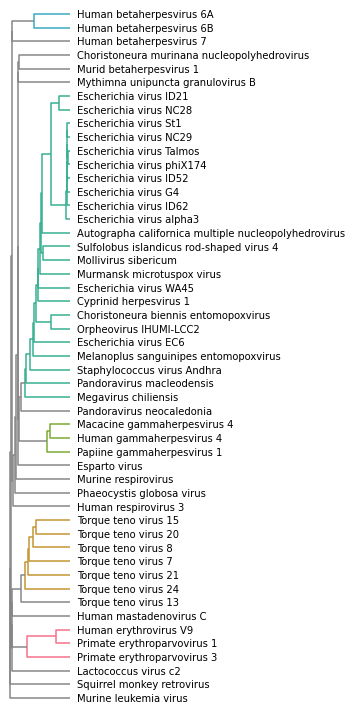

In [57]:
dists = 1-df_virus[select_viruses].corr('spearman')#pdist(df_bacteria.transpose(), 'braycurtis')
linkage_mat = linkage(squareform(dists))#, 'ward')
virus_order = df_virus[select_viruses].columns[leaves_list(linkage_mat)]
plt.figure(figsize=(5,10))
dn2 = dendrogram(linkage_mat, orientation='left', labels=select_viruses, color_threshold=0.8*np.max(linkage_mat[:,2]), get_leaves=True, above_threshold_color='#858585')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
plt.box(on=None)
plt.bbox_inches='tight'
plt.xticks([])
plt.tight_layout()
plt.savefig(fig_dir + 'virus_clusters_kraken.svg', transparent=True, bbox_inches='tight', format='svg', dpi=500)
plt.show()

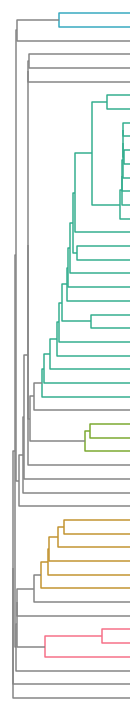

In [59]:
dists = 1-df_virus[select_viruses].corr('spearman')#pdist(df_bacteria.transpose(), 'braycurtis')
linkage_mat = linkage(squareform(dists))#, 'ward')
virus_order = df_virus[select_viruses].columns[leaves_list(linkage_mat)]
plt.figure(figsize=(2,10))
dn2 = dendrogram(linkage_mat, orientation='left', labels=['' for s in select_viruses], color_threshold=0.8*np.max(linkage_mat[:,2]), get_leaves=True, above_threshold_color='#858585')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
plt.box(on=None)
plt.bbox_inches='tight'
plt.xticks([])
plt.tight_layout()
plt.savefig(fig_dir + 'virus_clusters_kraken_nolabels.svg', transparent=True, bbox_inches='tight', format='svg', dpi=500)
plt.show()

In [60]:
### Hacky way to get colors right ###
# Viruses that don't belong to a cluster (bottom to top)
loners = [
'Human betaherpesvirus 7',
'Choristoneura murinana nucleopolyhedrovirus',
'Murid betaherpesvirus 1',
'Mythimna unipuncta granulovirus B',
'Pandoravirus neocaledonia',
'Esparto virus',
'Murine respirovirus',
'Phaeocystis globosa virus',
'Human respirovirus 3',
'Torque teno virus 13',
'Human mastadenovirus C',
'Lactococcus virus c2',
'Squirrel monkey retrovirus',
'Murine leukemia virus']

palette_dict = {p:i for i,p in enumerate(['#858585'] + palette)}
color_count = Counter([palette_dict[d] for d in dn2['color_list']])
color = np.array([0 for i in virus_order])
i_start = 0
for c in range(1,len(color_count)):
    while virus_order[i_start] in loners:
        i_start = i_start + 1
    i_end = i_start + color_count[c] + 1
    color[i_start:i_end] = c
    i_start = i_end
color_dict = {i:j for i,j in zip(virus_order, color)}

sns.set_palette(['#858585'] + palette)
df_melt = pd.melt(df_virus[virus_order[::-1]])
df_melt = df_melt[df_melt.value>0]
df_melt = df_melt[df_melt.value>0]
df_melt['color'] = [color_dict[v] for v in df_melt.variable]

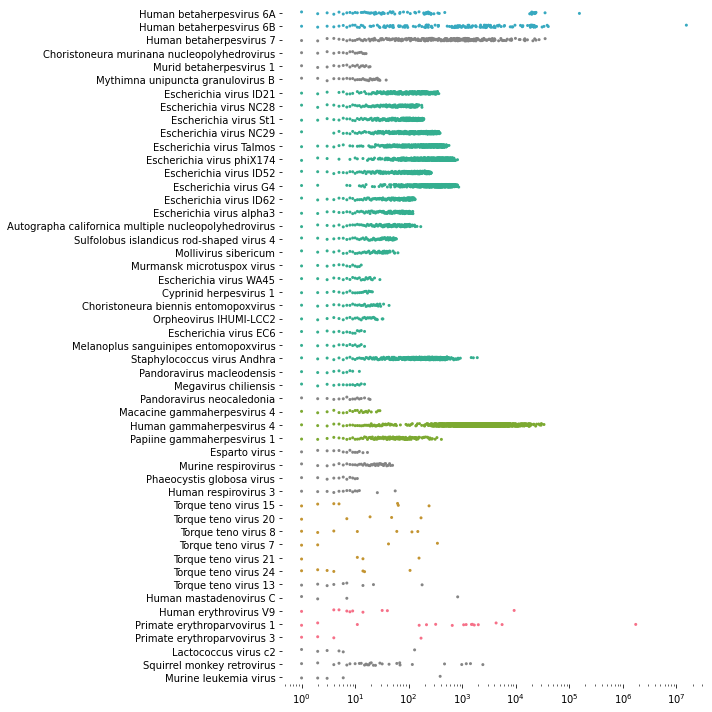

In [61]:
plt.figure(figsize=(10,10))
sns.stripplot(data=df_melt[~df_melt.duplicated()], y='variable', x='value', hue='color', jitter=.1, size=3)
plt.xscale('log')
plt.ylabel('')
plt.xlabel('')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
plt.box(on=None)
plt.legend().remove()
plt.tight_layout()
plt.savefig(fig_dir + 'virus_abundance_kraken.svg', transparent=True, bbox_inches='tight', format='svg', dpi=500)

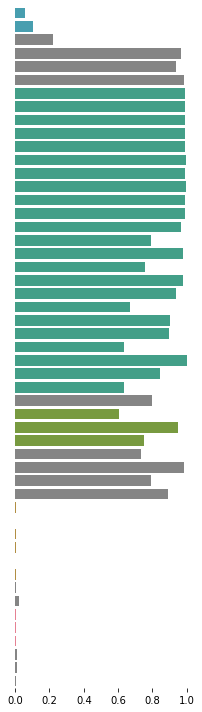

In [16]:
plt.figure(figsize=(3,10))
prevalence = pd.DataFrame((df_virus>0).mean(),columns=['prev'])
prevalence = prevalence.loc[virus_order[::-1]]
prevalence['microbe'] = prevalence.index
prevalence['color'] = [color_dict[v] for v in prevalence.microbe]
sns.barplot(data=prevalence, y='microbe', x='prev', hue='color', dodge=False)
plt.yticks([])
plt.ylabel('')
plt.xlabel('')
plt.legend().remove()
plt.box(on=None)
plt.tight_layout()
plt.savefig(fig_dir + 'virus_prevalence_kraken.svg', transparent=True, bbox_inches='tight', format='svg', dpi=500)

# Bacteria

In [39]:
df_bacteria

,Buchnera aphidicola,Sorangium cellulosum,Simonsiella muelleri,Cyclobacterium marinum,Isosphaera pallida,Borreliella burgdorferi,Borrelia hermsii,Borrelia coriaceae,Spirochaeta thermophila,Treponema denticola,...,Variovorax sp. 38R,Mesorhizobium sp. J8,Brevibacillus sp. JNUCC-41,Clostridium sp. 'deep sea',Bacillus sp. HD4P25,Echinicola sp. 20G,Labrys sp. KNU-23,Bacillus sp. V3,Kaistia sp. 32K,Metabacillus sp. cB07
MH0143019,63929,819,123,86,97,238,120,333,56,177,...,4,13,98,137,130,150,121,118,72,144
MH0143018,64386,775,123,91,82,222,148,271,62,186,...,5,4,77,148,121,163,124,99,60,144
MH0143013,66407,843,114,77,97,245,181,769,66,174,...,2,16,103,132,148,157,131,94,64,162
MH0143009,99110,622,184,145,54,318,223,273,49,263,...,12,14,106,216,130,172,121,99,41,142
MH0143008,55455,880,95,72,109,249,140,462,70,160,...,2,14,97,114,161,167,125,124,93,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02C10702,10181,631,25,11,28,108,32,16,76,30,...,61,47,21,17,64,80,110,32,58,31
02C10543,51173,1483,72,67,125,333,154,243,130,200,...,7,22,49,85,138,150,144,73,54,82
02C10542,36043,1108,48,55,130,285,90,80,81,139,...,4,122,52,48,111,188,144,46,75,50
02C10541,26993,1097,42,39,199,144,69,75,196,107,...,4,9,26,32,97,133,139,42,49,53


In [22]:
bacteria_abundant = df_bacteria.columns[np.argsort(df_bacteria.sum())[::-1]][:101]
bacteria_prevalent = []#df_bacteria.columns[np.argsort((df_bacteria>0).sum())[::-1]][:100]
select_bacteria = list(set(bacteria_abundant).union(set(bacteria_prevalent)))
select_bacteria = [s for s in select_bacteria if s !='Homo sapiens']

In [24]:
dists = 1-df_bacteria[select_bacteria].corr('spearman')#pdist(df_bacteria.transpose(), 'braycurtis')
linkage_mat = linkage(dists)
bacteria_order = list(df_bacteria[select_bacteria].columns[leaves_list(linkage_mat)])

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


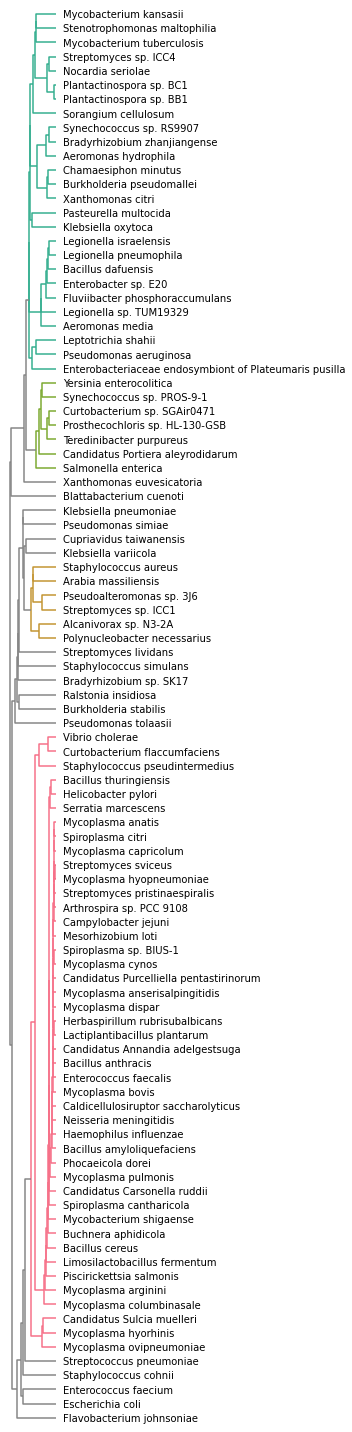

In [25]:
plt.figure(figsize=(5,20))
hierarchy.set_link_color_palette(palette)
dn2 = dendrogram(linkage_mat, orientation='left', labels=select_bacteria,color_threshold=0.6*np.max(linkage_mat[:,2]), above_threshold_color='#858585')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
plt.box(on=None)
plt.bbox_inches='tight'
plt.xticks([])
plt.tight_layout()
plt.savefig(fig_dir + 'bacteria_clusters.svg', transparent=True, bbox_inches='tight', format='svg', dpi=500)
plt.show()

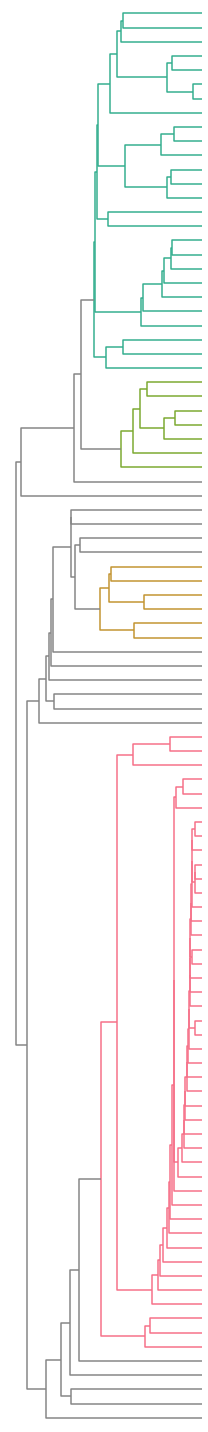

In [51]:
plt.figure(figsize=(3,20))
hierarchy.set_link_color_palette(palette)
dn2 = dendrogram(linkage_mat, orientation='left', labels=['' for s in select_bacteria],color_threshold=0.6*np.max(linkage_mat[:,2]), above_threshold_color='#858585')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
plt.box(on=None)
plt.bbox_inches='tight'
plt.xticks([])
plt.tight_layout()
plt.savefig(fig_dir + 'bacteria_clusters_no_labels.svg', transparent=True, bbox_inches='tight', format='svg', dpi=500)
plt.show()

In [27]:
### Hacky way to get colors right ###
#for v in bacteria_order[::-1]: print("'%s',"%v)
# Bacteria that don't belong to a cluster (bottom to top)
loners = [
'Xanthomonas euvesicatoria',
'Blattabacterium cuenoti',
'Klebsiella pneumoniae',
'Pseudomonas simiae',
'Cupriavidus taiwanensis',
'Klebsiella variicola',
'Streptomyces lividans',
'Staphylococcus simulans',
'Bradyrhizobium sp. SK17',
'Ralstonia insidiosa',
'Burkholderia stabilis',
'Pseudomonas tolaasii',
'Streptococcus pneumoniae',
'Staphylococcus cohnii',
'Enterococcus faecium',
'Escherichia coli',
'Flavobacterium johnsoniae',
]

palette_dict = {p:i for i,p in enumerate(['#858585'] + palette)}
color_count = Counter([palette_dict[d] for d in dn2['color_list']])
color = np.array([0 for i in bacteria_order])
i_start = 0
for c in range(1,len(color_count)):
    while bacteria_order[i_start] in loners:
        i_start = i_start + 1
    i_end = i_start + color_count[c] + 1
    color[i_start:i_end] = c
    i_start = i_end
color_dict = {i:j for i,j in zip(bacteria_order, color)}

In [28]:
sns.set_palette(['#858585'] + palette)
df_melt = pd.melt(df_bacteria[bacteria_order[::-1]])
df_melt = df_melt[df_melt.value>0]
df_melt['color'] = [color_dict[v] for v in df_melt.variable]

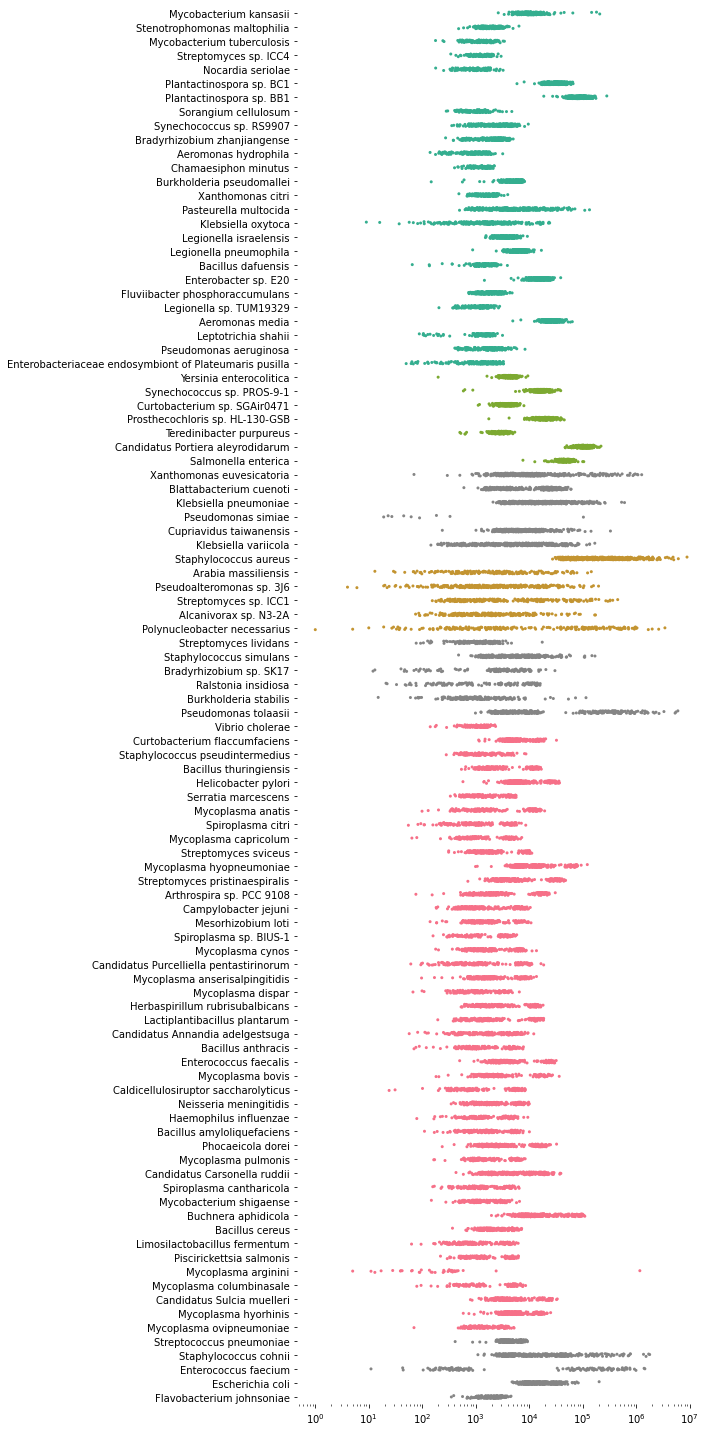

In [47]:
plt.figure(figsize=(10,20))
df_melt = pd.melt(df_bacteria[bacteria_order[::-1]])
df_melt = df_melt[df_melt.value>0]
df_melt = df_melt[df_melt.value>0]
df_melt['color'] = [color_dict[v] for v in df_melt.variable]
df_frac = df_melt[~df_melt.duplicated()].sample(frac=.1)
df_frac = df_frac.loc[sorted(df_frac.index)]
sns.stripplot(data=df_frac, y='variable', x='value', hue='color', jitter=.1, size=3)
plt.xscale('log')
plt.ylabel('')
plt.xlabel('')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
plt.box(on=None)
plt.legend().remove()
plt.tight_layout()
plt.savefig(fig_dir + 'bacteria_abundance.svg', transparent=True, bbox_inches='tight', format='svg', dpi=500)

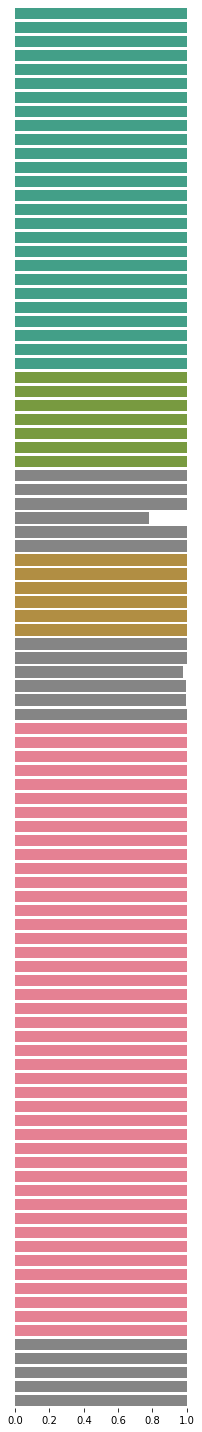

In [33]:
sns.set_palette(['#858585'] + palette)
plt.figure(figsize=(3,20))
prevalence = pd.DataFrame((df_bacteria>0).mean(),columns=['prev'])
prevalence = prevalence.loc[bacteria_order[::-1]]
prevalence['microbe'] = prevalence.index
prevalence['color'] = [color_dict[v] for v in prevalence.microbe]
sns.barplot(data=prevalence, y='microbe', x='prev', hue='color', dodge=False)
#plt.xscale('log')
plt.yticks([])
plt.ylabel('')
plt.xlabel('')
plt.legend().remove()
plt.box(on=None)
plt.tight_layout()
plt.savefig(fig_dir + 'bacteria_prevalence.svg', transparent=True, bbox_inches='tight', format='svg', dpi=500)